# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


CASE 1
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8,(8*1*1*768)] =>
    => 2 GRU((6144,512)|dropout(0.5)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]

CASE 2
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8*8,(1*1*768)] =>
    => 2 GRU((768,512)|drop_out(0.3)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]
    


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |


STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

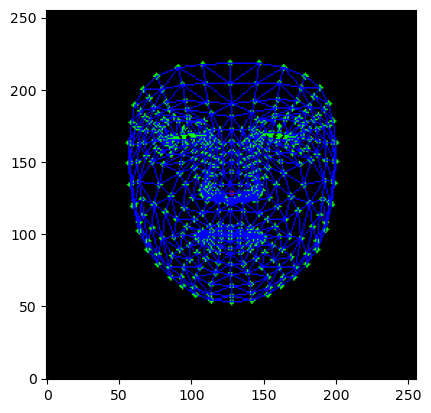

In [60]:
import numpy as np
import cv2
plt.gca().invert_yaxis()
plt.imshow(annotated_img[:,:,::-1]/255,origin='lower')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


W0000 00:00:1736195026.898485  435923 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1736195031.071517  435923 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1736195035.037053  435923 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


x: 128, y: 128
------------------------------
071309_w_21 saved in path partA/video/mean_face_landmarks_per_subject/071309_w_21.pkl
Processed 1/87 subjects
Expected end: 0 h 17 m 49 s
Total time  : 0 h 0 m 12 s
------------------------------


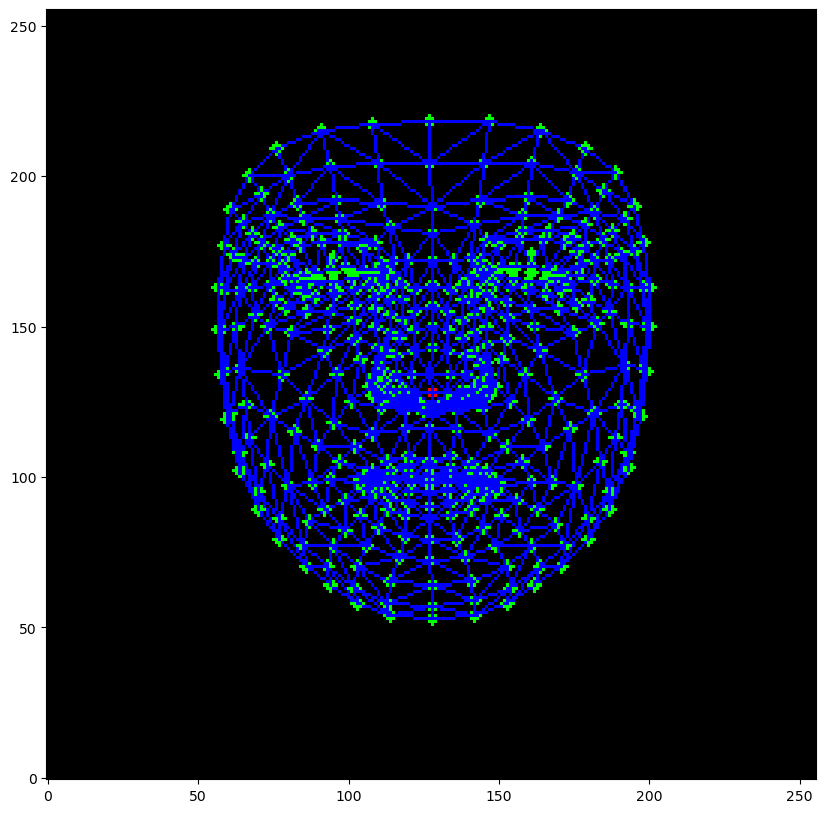

In [69]:
%load_ext autoreload
%autoreload 2
import numpy as np
import custom.faceExtractor as extractor
import os
import time
import pickle
import custom.tools as tools

import numpy as np
import custom.faceExtractor as extractor
import os
import time
import cv2
import pickle
import custom.tools as tools
import matplotlib.pyplot as plt
# subject_name = '112016_m_25'

root_video_path = 'partA/video/video'
csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.unique(csv_array[:,1])
face_ln_saving_folder = 'partA/video/mean_face_landmarks_per_subject'
saving_plot_landmarks_folder = os.path.join(face_ln_saving_folder,'plot_landmarks')
if not os.path.exists(saving_plot_landmarks_folder):
  os.makedirs(saving_plot_landmarks_folder)
if not os.path.exists(face_ln_saving_folder):
  os.makedirs(face_ln_saving_folder)
face_extractor = extractor.FaceExtractor()
start = time.time()
count = 0

for subject_name in list_subject_name:
  folder_path = os.path.join(root_video_path, subject_name)
  all_videos = os.listdir(folder_path)
  list_video_path = [os.path.join(folder_path, video) for video in all_videos]
  all_mean_facial_landmarks,count_frame=face_extractor.get_mean_facial_landmarks(list_video_path=list_video_path[:3],
                                                                                 align=True,
                                                                                 numpy_view=True)
  dict_subject = {'subject_name':subject_name,
                  'mean_facial_landmarks':all_mean_facial_landmarks,
                  'count_frame':count_frame}
  
  with open(os.path.join(face_ln_saving_folder,subject_name+'.pkl'), 'wb') as f:
    pickle.dump(dict_subject, f)
  all_mean_facial_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(all_mean_facial_landmarks)
  img = np.zeros((256,256,3))
  annotated_img = face_extractor.plot_landmarks(image=img,landmarks=all_mean_facial_landmarks,connections=face_extractor.FACE_TESSELATION)
  
  # print(np.max(annotated_img))
  # cv2.imwrite(os.path.join(saving_plot_landmarks_folder,subject_name+'.png'),annotated_img)
  # fig, ax = plt.subplots(figsize=(10,10))
  # im = ax.imshow(annotated_img[:,:,::-1]/255,origin='lower')
  # plt.savefig(os.path.join(saving_plot_landmarks_folder,subject_name+'.png'))
  total_time = time.time()-start
  count += 1
  expected_time = total_time/count*len(list_subject_name)
  print('-'*30)
  print(f'{subject_name} saved in path {os.path.join(face_ln_saving_folder,subject_name+".pkl")}')
  print(f'Processed {count}/{len(list_subject_name)} subjects')
  print(f'Expected end: {int(expected_time/60/60)} h {int(expected_time/60)%60} m {int(expected_time)%60} s')
  print(f'Total time  : {int(total_time/60/60)} h {int(total_time/60)%60} m {int(total_time)%60} s')
  print('-'*30)
  


x: 128, y: 128


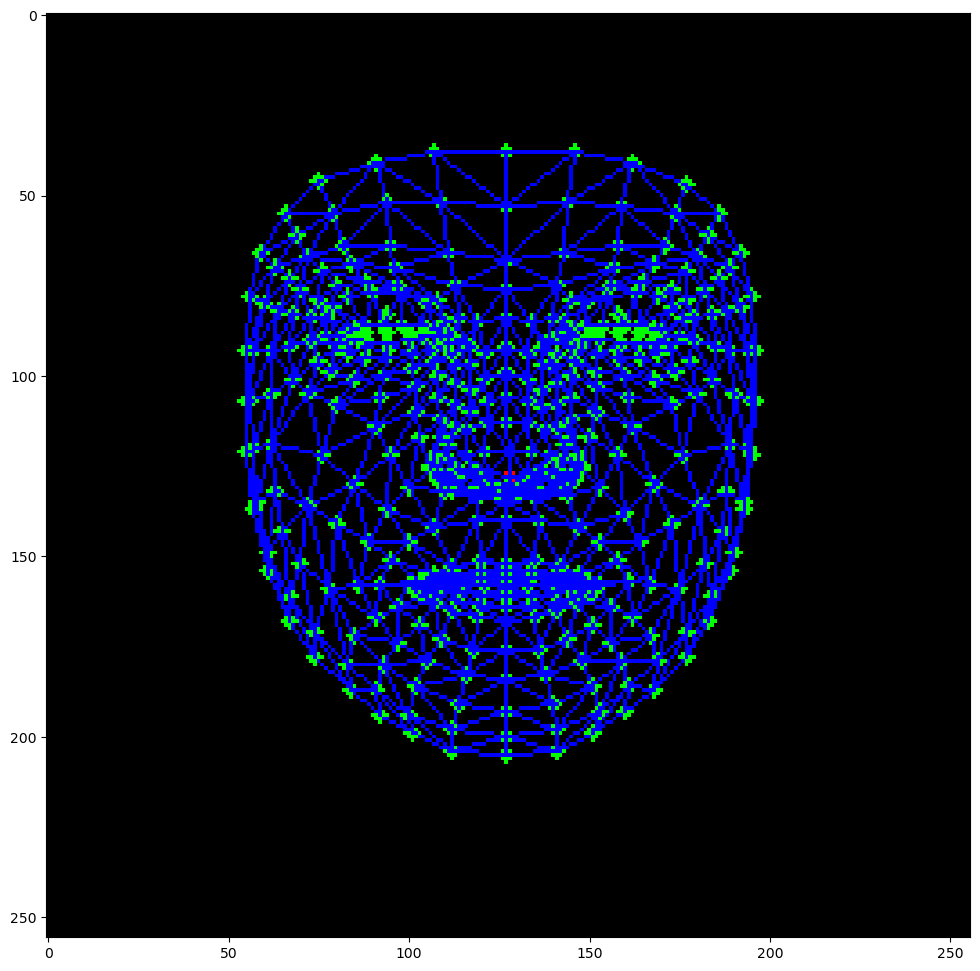

In [31]:
import matplotlib.pyplot as plt

csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.unique(csv_array[:,1])
all_mean_facial_landmarks = np.zeros((478,3),dtype=np.float32)
face_ln_saving_folder = 'partA/video/mean_face_landmarks_per_subject'

for subject_name in list_subject_name:
  count+=1
  with open(os.path.join(face_ln_saving_folder,subject_name+'.pkl'), 'rb') as f:
    dict_subject = pickle.load(f)
    mean_facial_landmarks = dict_subject['mean_facial_landmarks']
    count_frame = dict_subject['count_frame']
        
  black_img = np.zeros((256,256,3), dtype=np.uint8)
  
  all_mean_facial_landmarks += mean_facial_landmarks - mean_facial_landmarks[extractor.FaceExtractor.NOSE_INDEX] + 0.5

all_mean_facial_landmarks /= len(list_subject_name)  
ln = face_extractor.convert_from_numpy_to_NormalizedLandmark(all_mean_facial_landmarks)
annotated_image = face_extractor.plot_landmarks(image=black_img, 
                                                landmarks=ln,
                                                connections=face_extractor.FACE_TESSELATION)

dict_subject = {'mean_facial_landmarks':all_mean_facial_landmarks,
                'count_subject':count}

# with open(os.path.join(face_ln_saving_folder,'all_subjects_mean_landmarks.pkl'), 'wb') as f:
#   pickle.dump(dict_subject, f)
  
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
# saving_path = os.path.join(face_ln_saving_folder,'plot_landmarks','all_subjects_mean_landmarks'+'.png')
# if not os.path.exists(os.path.dirname(saving_path)):
#   os.makedirs(os.path.dirname(saving_path))
# plt.savefig(saving_path)

[[0.49890456 0.597015   0.5624743 ]
 [0.5        0.5        0.5       ]
 [0.4988874  0.5280518  0.5619727 ]
 ...
 [0.6207666  0.32502288 0.65078235]
 [0.5961671  0.34442765 0.65075076]
 [0.6189024  0.36571935 0.65075475]]


W0000 00:00:1736183025.719096  433996 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


---------------------------------
Processed 100/8700 videos
Total time: 4.41 s
---------------------------------


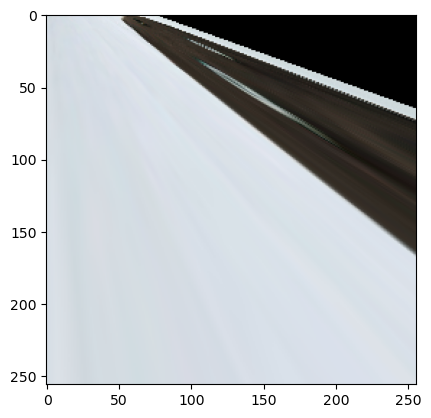

In [ ]:
import numpy as np
import custom.faceExtractor as extractor
import os
import time
import cv2
import pickle
import custom.tools as tools
import matplotlib.pyplot as plt


csv_path = os.path.join("partA", "starting_point", "samples.csv")
csv_array,_ = tools.get_array_from_csv(csv_path=csv_path)
video_folder_path = os.path.join("partA", "video", "video")
extracted_video_folder_path = os.path.join("partA", "video", "extracted_video")
landmarks_folder_path = os.path.join("partA", "video", "mean_face_landmarks_per_subject")
# ['subject_id', 'subject_name', 'class_id', 'class_name', 'sample_id', 'sample_name']
list_video_path = [os.path.join(video_folder_path, sample[1],sample[5]+".mp4") for sample in csv_array]
face_extractor = extractor.FaceExtractor()
count = 0
start = time.time()
saving_path_ln = os.path.join(landmarks_folder_path, "all_subjects_mean_landmarks.pkl")
with open(saving_path_ln, 'rb') as f:
  reference_landmarks = pickle.load(f)
reference_landmarks = reference_landmarks['mean_facial_landmarks']
print(reference_landmarks)
target_coords = {
        'x':0.5,
        'y':0.5,
        'z':0.5
      }

for subject_name,sample_name in zip(csv_array[:,1],csv_array[:,5]):
  if subject_name == '071309_w_21':
    count+=1
    continue
  else:
    video_path = os.path.join(video_folder_path,subject_name,sample_name+'.mp4')
    frame_list = face_extractor._get_list_frame(list_video_path[0], align=True)
    list_landmarks_video = face_extractor.predict_landmarks(frame_list=frame_list)
    for landmarks_frame,(frame,_) in zip(list_landmarks_video,frame_list):
      shift = {
        'x':target_coords['x'] - landmarks_frame.face_landmarks[0][face_extractor.NOSE_INDEX].x,
        'y':target_coords['y'] - landmarks_frame.face_landmarks[0][face_extractor.NOSE_INDEX].y,
        'z':target_coords["z"] - landmarks_frame.face_landmarks[0][face_extractor.NOSE_INDEX].z
      }
      centered_lm = np.array([[shift['x']+lm.x,shift['y']+lm.y, shift['z']+lm.z ] for lm in landmarks_frame.face_landmarks[0]])
      
    # frame = face_extractor._extract_face_oval_from_img(img=frame,
    #                                                   routes=reference['mean_facial_landmarks'])
    # plt.imshow(frame)
    # face_extractor.warp_face(target_img=fr)
    if count % 1 == 0:
      print('---------------------------------')
      print(f'Processed {count}/{len(csv_array[:,5])} videos')
      print(f'Total time: {time.time()-start:.2f} s')
      print('---------------------------------')
      # clear console output    
    break

W0000 00:00:1736089612.202750   31732 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Total time: 2.65 s


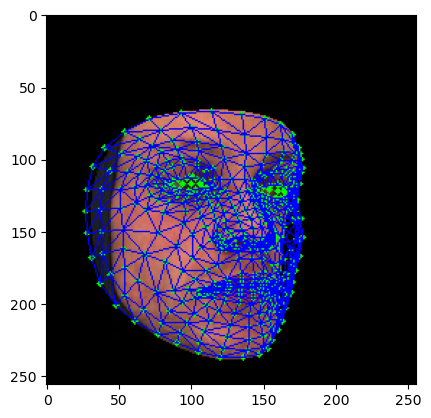

In [ ]:
# partA/video/video/112016_m_25/112016_m_25-PA4-064.mp4
import os

import time
import custom.faceExtractor as extractor
import cv2
import matplotlib.pyplot as plt
face_extractor = extractor.FaceExtractor()
path_video_input = os.path.join("partA", "video", "video", "112016_m_25", "112016_m_25-PA4-064.mp4")
path_video_output = os.path.join("partA", "video", "extracted_video", "112016_m_25", "112016_m_25-PA4-064.mp4")
start = time.time()
# face_extractor.generate_face_oval_video(path_video_input=path_video_input,
#                                         path_video_output=path_video_output,
#                                         align=True)
list_annotated_image = face_extractor.get_frames_annotated(path_video_input=path_video_output)
# plot list_annotated_image[0]
print(f'Total time: {time.time()-start:.2f} s')
plt.imshow(cv2.cvtColor(list_annotated_image[0], cv2.COLOR_BGR2RGB))
# cv2.imshow('Landmarks', list_annotated_image[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [3]:
avg_time = 5
h = int(8700 * avg_time / 60 / 60)
s = (8700 * avg_time / 60) % 60
print(f'Total time: {h:.0f} h {s:.0f} m')

Total time: 12 h 5 m


# Code

20 participants who did not react visibly to the applied pain stimuli:
- ID:27, 082315_w_60 
- ID:28, 082414_m_64
- ID:32, 082909_m_47
- ID:33, 083009_w_42
- ID:34, 083013_w_47
- ID:35, 083109_m_60
- ID:36, 083114_w_55
- ID:39, 091914_m_46
- ID:40, 092009_m_54
- ID:41, 092014_m_56
- ID:42, 092509_w_51
- ID:44, 092714_m_64
- ID:51, 100514_w_51
- ID:53, 100914_m_39
- ID:55, 101114_w_37
- ID:56, 101209_w_61
- ID:61, 101809_m_59
- ID:64, 101916_m_40
- ID:74, 111313_m_64
- ID:87, 120614_w_61

In [ ]:
%load_ext autoreload
%autoreload 2
import custom.tools as tools
import custom.scripts as scripts
import os
import time
# OK finish the video clip, start to create plot list_same_clip_positions many people
# try to combine plot and video in one
folder_tsne_results = os.path.join('tsne_Results',f'test_{str(int(time.time()))}')
folder_path_features = os.path.join('partA','video','features','samples_16')

if not os.path.exists(folder_tsne_results):
    os.makedirs(folder_tsne_results)

# stoic subjects = [27,28,32,33,34,35,36,39,40,41,42,44,51,53,55,56,61,64,74,87]
subject_id_list = [1]
clip_list = [0,1,2,3,4,5,6,7]
class_list = [4,3,2,1,0]
sample_id_list = None
sliding_windows =  16
legend_label = 'clip' # can be clip, subject and class    
scripts.plot_and_generate_video(folder_path_features=folder_path_features,
                                folder_path_tsne_results=folder_tsne_results,
                                subject_id_list=subject_id_list,
                                clip_list=clip_list,
                                legend_label=legend_label,
                                class_list=class_list,
                                sliding_windows=sliding_windows,
                                # plot_only_sample_id_list=sample_id_list,
                                plot_third_dim_time=False,
                                create_video=True,
                                apply_pca_before_tsne=False,
                                tsne_n_component=2,
                                sort_elements=True,
                                cmap='copper')


/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

dict_all_features["list_subject_id"] shape torch.Size([69600])
Elasped time to get all features:  0.049924373626708984
list_frames torch.Size([800, 16])
list_sample_id torch.Size([800])
list_video_path (800,)
list_feature torch.Size([800, 8, 1, 1, 768])
list_idx_list_frames (800,)
list_y_gt torch.Size([800])
TSNE_X.shape: torch.Size([800, 8, 1, 1, 768])
Using CPU
Start t-SNE computation...
X_tsne shape: (800, 2)
Plot saved to tsne_Results/test_1734624702/_.png
axis_dict {'min_x': -45.911114586688164, 'min_y': -55.54092918217133, 'max_x': 46.468452529475016, 'max_y': 48.627928252559585}
Plot saved to tsne_Results/test_1734624702/tsne_plot_16_clip/sliding_16_tot-subjects_1__clips_[0, 1, 2, 3, 4, 5, 6, 7]__classes_[4, 3, 2, 1, 0]_clip.png
Elapsed time to get all plots: 85.62082552909851 s
Generating video...
video_path: partA/video/video/071309_w_21/071309_w_21-PA4-002.mp4
video_path: partA/video/video/071309_w_21/071309_w_21-PA4-003.mp4
Processed 10/800 videos
video_path: partA/video/vid

: 

In [1]:
import custom.tools as tools  
import os
dict_data=tools.load_dict_data(saving_folder_path=os.path.join('partA','video','features','samples_16'))
for k,v in dict_data.items():
    print(k,v.shape)

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

list_labels torch.Size([69600])
features torch.Size([69600, 8, 1, 1, 768])
list_path (69600,)
list_sample_id torch.Size([69600])
list_frames torch.Size([69600, 16])
list_subject_id torch.Size([69600])


In [ ]:
%load_ext autoreload
%autoreload 2
from custom.dataset import customDataset
from custom.backbone import backbone
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
from transformers import AutoImageProcessor

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

path_dataset = os.path.join('partA','video','video')
path_labels = os.path.join('partA','starting_point','samples.csv')

def _extract_features(dataset,path_csv_dataset,batch_size_feat_extraction,backbone):
  """
  Extract features from the dataset specified by the CSV file path.

  Args:
    path_csv_dataset (str): Path to the CSV file containing dataset information.
    batch_size (int, optional): Number of samples per batch to load. Default is 2.

  Returns:
    dict: A dictionary containing the following keys:
      - 'features' (torch.Tensor): shape [n_video * n_clips, temporal_dim=8, patch_h, patch_w, emb_dim].
      - 'list_labels' (torch.Tensor): shape [n_video * n_clips].
      - 'list_subject_id' (torch.Tensor): shape (n_video * n_clips).
      - 'list_sample_id' (torch.Tensor): shape (n_video * n_clips).
      - 'list_path' (np.ndarray): shape (n_video * n_clips,).
      - 'list_frames' (torch.Tensor): shape [n_video * n_clips, n_frames].

  """
  
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"extracting features using.... {device}")
  list_features = []
  list_labels = []
  list_subject_id = []
  list_sample_id = []
  list_path = []
  list_frames = []
  count = 0
  dataset.set_path_labels(path_csv_dataset)
  dataloader = DataLoader(dataset, 
                          batch_size=batch_size_feat_extraction,
                          # num_workers=1,
                          shuffle=False,
                          collate_fn=dataset._custom_collate_fn)
  # move the model to the device
  backbone.model.to(device)
  backbone.model.eval()
  with torch.no_grad():
    # start_total_time = time.time()
    start = time.time()
    for data, labels, subject_id,sample_id, path, list_sampled_frames in dataloader:
      #############################################################################################################
      # data shape -> [nr_clips, clip_length=16, channels=3, H=224, W=224]
      # 
      # nr_clips  = floor((total_frames-clip_length=16)/stride_window) + 1
      #           BIOVID -> floor((138-16)/4)) + 1 = 31
      # 
      # self.backbone.model ->   85 MB (small_model), 
      #                         400 MB (base_model), 
      #                           4 GB (giant_model)
      # 
      # video_feat_size [nr_video,8,768] => 8700 * 8 * 768 * 4 = 204 MB
      #############################################################################################################
      # print(f'Elapsed time for {batch_size} samples: {time.time() - start}')
      print(f'data shape {data.shape}')
      data = data.to(device)
      with torch.no_grad():
    # Extract features from clips -> return [B, clips/tubelets, W/patch_w, H/patch_h, emb_dim] 
        feature = backbone.forward_features(x=data)
      # feature -> [2, 8, 1, 1, 384]
      list_frames.append(list_sampled_frames)
      list_features.append(feature.detach().cpu())
      list_labels.append(labels)
      list_sample_id.append(sample_id)
      list_subject_id.append(subject_id)
      list_path.append(path)
      count += 1
      # if count % 10 == 0:
      print(f'Batch {count}/{len(dataloader)}')
      print(f' Time {int((time.time() - start)/60)} m : {int((time.time() - start)%60)} s')
      print(f' GPU:\n  Free : {torch.cuda.mem_get_info()[0]/1024/1024/1024:.2f} GB \n  total: {torch.cuda.mem_get_info()[1]/1024/1024/1024:.2f} GB')
      del data, feature
      torch.cuda.empty_cache()
      # start = time.time()
  # print(f'Elapsed time for total feature extraction: {time.time() - start_total_time}')
  # print('Feature extraceton done')
  backbone.model.to('cpu')
  # print('backbone moved to cpu')
  # print(f'torch.cat features {torch.cat(list_features,dim=0).shape}')
  dict_data = {
    'features': torch.cat(list_features,dim=0),  # [n_video * n_clips, temporal_dim=8, patch_h, patch_w, emb_dim] 630GB
    'list_labels': torch.cat(list_labels,dim=0),  # [n_video * n_clips] 8700 * 10 * 4 = 340 KB
    'list_subject_id': torch.cat(list_subject_id).squeeze(),  # (n_video * n_clips) 8700 * 10 * 4 = 340 KB
    'list_sample_id': torch.cat(list_sample_id),  # (n_video * n_clips) 8700 * 10 * 4 = 340 KB
    'list_path': np.concatenate(list_path),  # (n_video * n_clips,) 8700 * 10 * 4 = 340 KB
    'list_frames': torch.cat(list_frames,dim=0)  # [n_video * n_clips, n_frames] 8700 * 10 * 4 = 340 KB
  }

  return dict_data 

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
custom_ds = customDataset(path_dataset=path_dataset,
                          path_labels=path_labels,
                          sample_frame_strategy=sample_frame_strategy,
                          stride_window=4,
                          preprocess=preprocess,
                          clip_length=16)
backbone_model = backbone(model_type=model_type)

dict_data = _extract_features(dataset=custom_ds,
                              path_csv_dataset=path_labels,
                              batch_size_feat_extraction=1,
                              backbone=backbone_model)

In [1]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
import torch.nn as nn
import torch.optim as optim
import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','samples.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 1024,
  'num_layers': 1,
  'dropout': 0.0,
  'input_size': 768 * 8 # can be 384  (small), 768  (base), 1408  (large) [temporal_dim considered as input sequence for GRU]
                    # can be 384*8(small), 768*8(base), 1408*8(large) [temporal_dim considered feature in GRU] 
}

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
stride_window_in_video = 4
model_advanced = scripts.run_train_test(model_type=model_type, 
                      pooling_embedding_reduction=pooling_embedding_reduction, 
                      pooling_clips_reduction=pooling_clips_reduction, 
                      sample_frame_strategy=sample_frame_strategy, 
                      path_csv_dataset=path_cvs_dataset, 
                      path_video_dataset=path_dataset,
                      head=head,
                      stride_window_in_video=stride_window_in_video, 
                      head_params=params,
                      preprocess=preprocess,
                      k_fold = 5,
                      epochs = 5,
                      train_size=0.8,
                      test_size=0.1,
                      val_size=0.1,
                      batch_size_training=1024,
                      batch_size_feat_extraction=8,  
                      criterion = nn.L1Loss(),
                      optimizer_fn = optim.SGD,
                      lr = 0.0001,
                      random_state_split_dataset=42,
                      only_train=False,
                      is_save_features_extracted=False, 
                      is_validation=True,
                      is_plot_dataset_distribution=True,
                      is_plot_loss=True,
                      is_plot_tsne_backbone_feats=True,
                      is_plot_tsne_head_pred=True,
                      is_plot_tsne_gru_feats=True,
                      is_create_video_prediction=True,
                      is_create_video_prediction_per_video=True,
                      is_round_output_loss=False,
                      is_shuffle_training_batch=True,
                      is_shuffle_video_chunks=False,
                      is_download_if_unavailable=False
                      )

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Set path_labels: partA/starting_point/samples.csv
Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243
 list_splits_idxs [array([   0,    1,    2, ..., 8197, 8198, 8199]), array([ 100,  101,  102, ..., 8297, 8298, 8299]), array([ 200,  201,  202, ..., 8397, 8398, 8399]), array([ 300,  301,  302, ..., 8697, 8698, 8699]), array([ 400,  401,  402, ..., 8597, 8598, 8599])]
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/test.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/val.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/train.csv
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/train.csv
Loading features from SSD...


: 

In [ ]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

In [ ]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       